In [1]:
import numpy as np
import copy
import h5py
import hdf5plugin as h5pl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable
from skimage.filters.rank import entropy
from skimage.morphology import disk, square
from skimage.metrics import mean_squared_error as mse
import seaborn as sns
import pandas as pd
import math
from tifffile import imread
import scipy
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from skimage.measure import profile_line
import matplotlib.gridspec as gridspec
from PIL import Image
from scipy.ndimage import uniform_filter
import cmasher as cmr
import scipy.stats
from matplotlib.offsetbox import AnchoredText
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
font = {
        'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 7
        }
padding = {
    'titlepad': 3,
    'labelpad': 1,
}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **padding)

In [3]:
def readImage(filestr):
    f = h5py.File(filestr, 'r')
    img = np.amax(f['data'][500:1000, :-64, 64:], axis=0)
    
    f.close()
    # img = img[:256, -384:-128]
    img = img[:1024, -1024:]
    img = Image.fromarray(img).resize((256, 256))
    return np.array(img)

In [4]:
def normalize(im):
    return im / np.amax(im)

In [5]:
def quant(img, beta=0.5, norm=False, linear=False, max_val=65535):
    if norm:
        cs_img = np.array(np.round(np.power(normalize(img), beta) * 255), dtype=img.dtype)
        rec_img = np.array(np.round(np.power(normalize(cs_img), 1 / beta) * max_val), dtype=img.dtype)
    elif linear:
        cs_img = np.array(np.round(normalize(img) * 255), dtype=img.dtype)
        rec_img = np.array(np.round(normalize(cs_img) * max_val), dtype=img.dtype)
    else:
        cs_img = np.array(np.round(np.power(img, beta)), dtype=img.dtype)
        rec_img = np.array(np.round(np.power(cs_img, 1 / beta)), dtype=img.dtype)
    return cs_img, rec_img

In [6]:
def window_variance(arr, radius=3):
    # E[(X - E[X])^2] = E[X^2] - E[X]^2
    c1 = uniform_filter(arr, radius*2, mode='constant', origin=-radius)
    c2 = uniform_filter(arr*arr, radius*2, mode='constant', origin=-radius)
    return ((c2 - c1*c1))[:-radius*2+1,:-radius*2+1]

In [7]:
img_file = '/data/duanb/DRAQ5/coord_-5.2,+18.6_2_1X.h5'

In [8]:
img = readImage(img_file)
img.shape, img.dtype, np.amax(img), np.amin(img)

((256, 256), dtype('uint16'), 3941, 229)

In [9]:
Image.fromarray(img).save('sample.tif')

In [10]:
# Make a line with "num" points...
x0, y0 = 80, 45
x1, y1 = 120, 75
lineIntensity = profile_line(img, (y0, x0), (y1, x1))

In [11]:
max_lineIntensity, min_lineIntensity = np.amax(lineIntensity), np.amin(lineIntensity)

In [12]:
img = np.array(img, dtype=np.float32)
math.log(255, np.amax(img))

0.6693002207078058

In [13]:
lq, rec_lq = quant(img, linear=True, max_val=np.amax(img))
sq, rec_sq = quant(img, beta=0.5, max_val=np.amax(img))
gq, rec_gq = quant(img, beta=math.log(255, np.amax(img)), max_val=np.amax(img))

In [14]:
en_img = entropy(np.array(img, dtype=np.uint16), disk(5))
en_lq = entropy(np.array(rec_lq, dtype=np.uint16), disk(5))
en_sq = entropy(np.array(rec_sq, dtype=np.uint16), disk(5))
en_gq = entropy(np.array(rec_gq, dtype=np.uint16), disk(5))

/home/duanb/mambaforge/envs/ffmpeg_dev/lib/python3.11/site-packages/skimage/filters/rank/generic.py:268: UserWarning: Bad rank filter performance is expected due to a large number of bins (3942), equivalent to an approximate bitdepth of 11.9.
  image, footprint, out, mask, n_bins = _preprocess_input(image, footprint,
/home/duanb/mambaforge/envs/ffmpeg_dev/lib/python3.11/site-packages/skimage/filters/rank/generic.py:268: UserWarning: Bad rank filter performance is expected due to a large number of bins (3970), equivalent to an approximate bitdepth of 12.0.
  image, footprint, out, mask, n_bins = _preprocess_input(image, footprint,


In [15]:
bead = Image.open('bead.png').resize((512, 512))
bead = np.array(bead) / 256
bead = bead.astype(np.uint16)

np.amax(bead), np.amin(bead)

(255, 0)

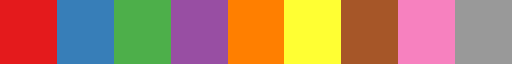

In [16]:
plt.colormaps['Set1']

In [17]:
colors = plt.colormaps['Set1'].colors
colors = [colors[0], colors[1], colors[2], colors[4]]

In [19]:
colors

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (1.0, 0.4980392156862745, 0.0)]

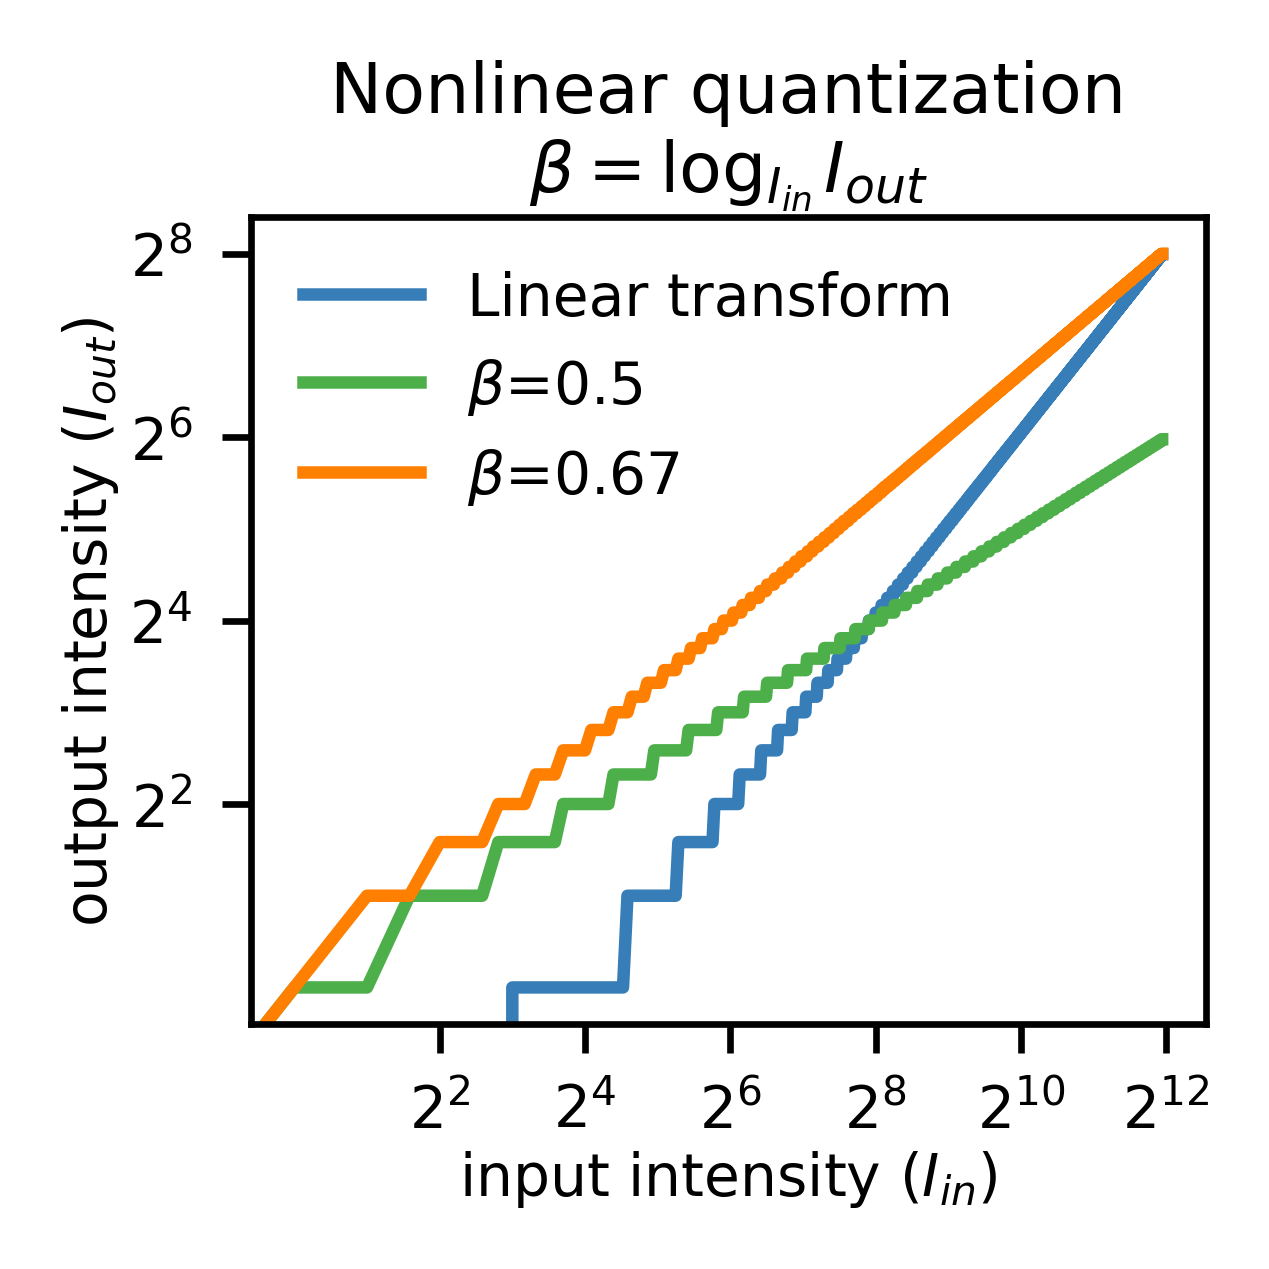

In [64]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2,2), dpi=600, layout='constrained')

sns.set_palette('Set2')

ax.plot(np.array(range(3941)), np.around(np.array(range(3941)) / 3941 * 255), label='Linear transform', color=colors[1])
ax.plot(np.array(range(3941)), np.around(np.power(np.array(range(3941)), 0.5)), label='$\\beta$=0.5', color=colors[2])
ax.plot(np.array(range(3941)), np.around(np.power(np.array(range(3941)), 0.67)), label='$\\beta$=0.67', color=colors[3])

# ax.hlines(256, xmin=0.1, xmax=65536, linestyles='--', color='gray')
# ax.hlines(1024, xmin=0.1, xmax=65536, linestyles='--', color='gray')
# # ax.vlines(65536, ymin=0, ymax=256, linestyles='--', color='gray')
# ax.vlines(7087, ymin=0, ymax=1024, linestyles='dotted', color='gray')

ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)
ax.set_xlabel('input intensity ($I_{in}$)')
ax.set_ylabel('output intensity ($I_{out}$)')
ax.set_xticks([4, 16, 64, 256, 1024, 4096], ['$2^2$', '$2^{4}$', '$2^{6}$','$2^{8}$', '$2^{10}$','$2^{12}$'])
ax.set_yticks([4, 16, 64, 256], ['$2^2$', '$2^{4}$', '$2^{6}$','$2^{8}$'])
# ax.set_ylim(0.1, 2**16)
# ax.set_xlim(0.1, 2**16)

ax.set_title('Nonlinear quantization\n$\\beta=\log_{I_{in}} I_{out}$')
# ax.legend(loc='upper left', frameon=False, bbox_to_anchor=(0, 0.75))
ax.legend(loc='upper left', frameon=False)

fig.savefig('beta_part1.pdf')

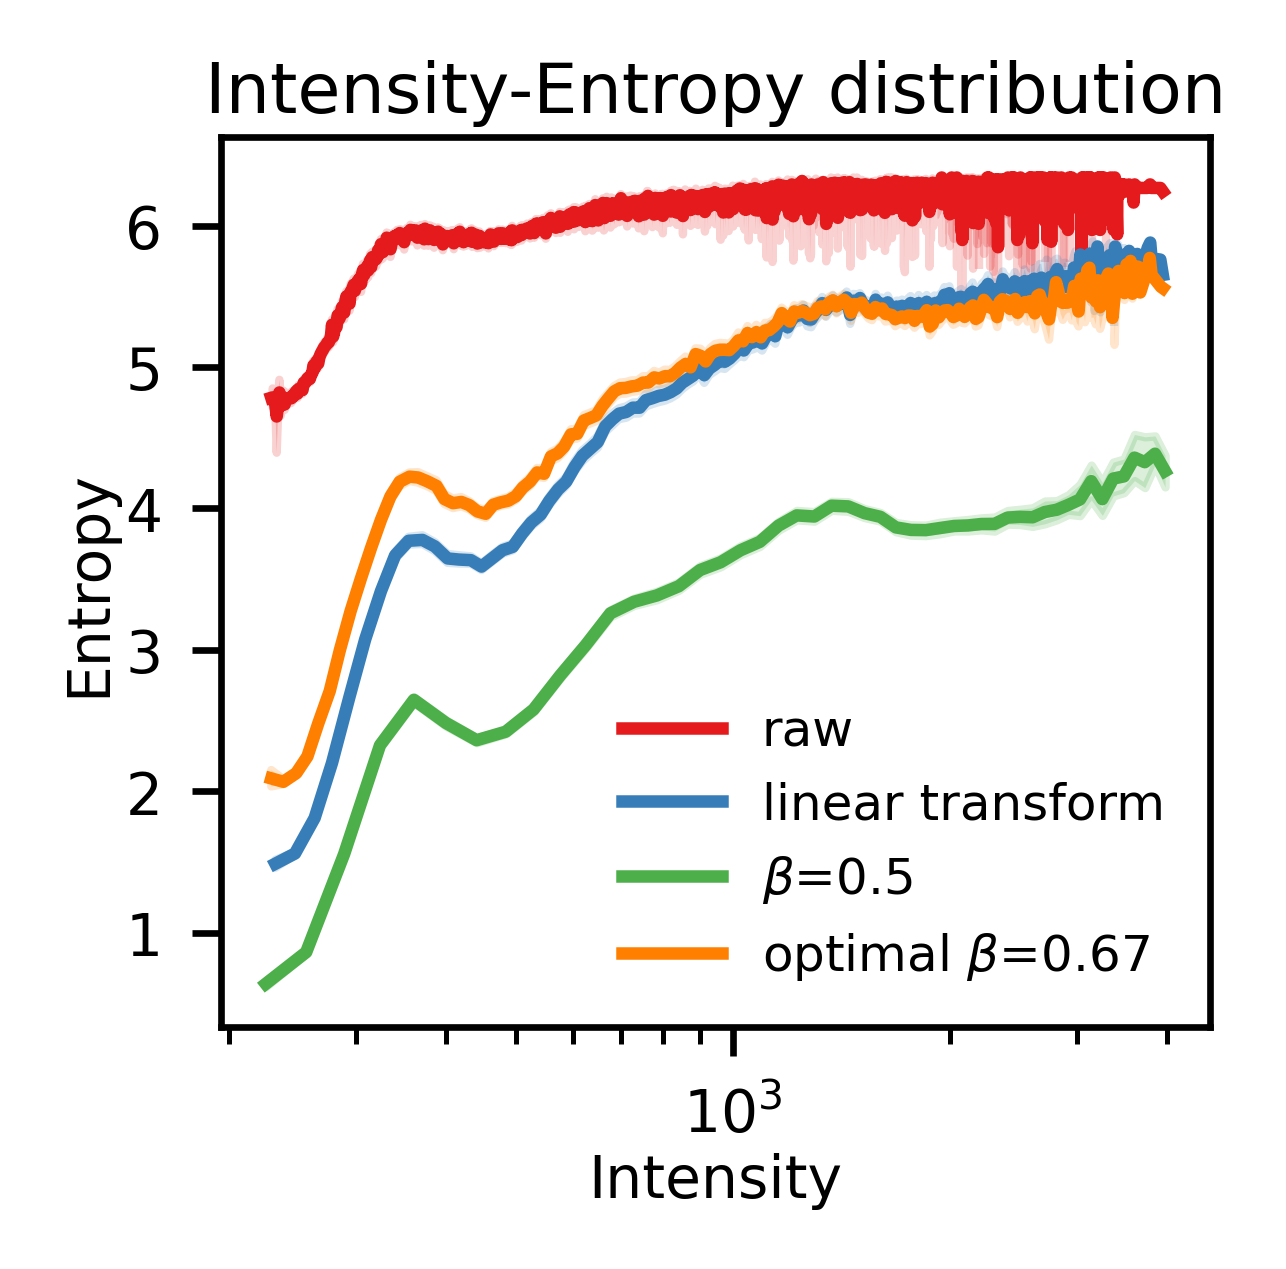

In [36]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2,2), dpi=600, layout='constrained')

# sns.set_palette('Set2')

d = {'Intensity': [], 'Entropy': [], 'Labels': []}

im_vals = []
en_vals = []
labs = []
for im, en_im, label in zip([img, rec_lq, rec_sq, rec_gq], [en_img, en_lq, en_sq, en_gq], ['raw', 'linear transform', '$\\beta$=0.5', 'optimal $\\beta$=0.67']):
    for i, j in zip(im.flatten(), en_im.flatten()):
        im_vals.append(i)
        en_vals.append(j)
        labs.append(label)

d['Intensity'] = im_vals
d['Entropy'] = en_vals
d['Labels'] = labs
df = pd.DataFrame(data=d)

sns.lineplot(data=df, x='Intensity', y='Entropy', hue='Labels', ax=ax, palette=colors)
ax.set_ylabel('Entropy')
# ax.set_ylim(0, 8)
ax.set_xscale("log")
ax.legend(frameon=False, fontsize=6)
ax.set_xlabel('Intensity')
ax.set_title('Intensity-Entropy distribution')

fig.savefig('beta_part2.pdf')

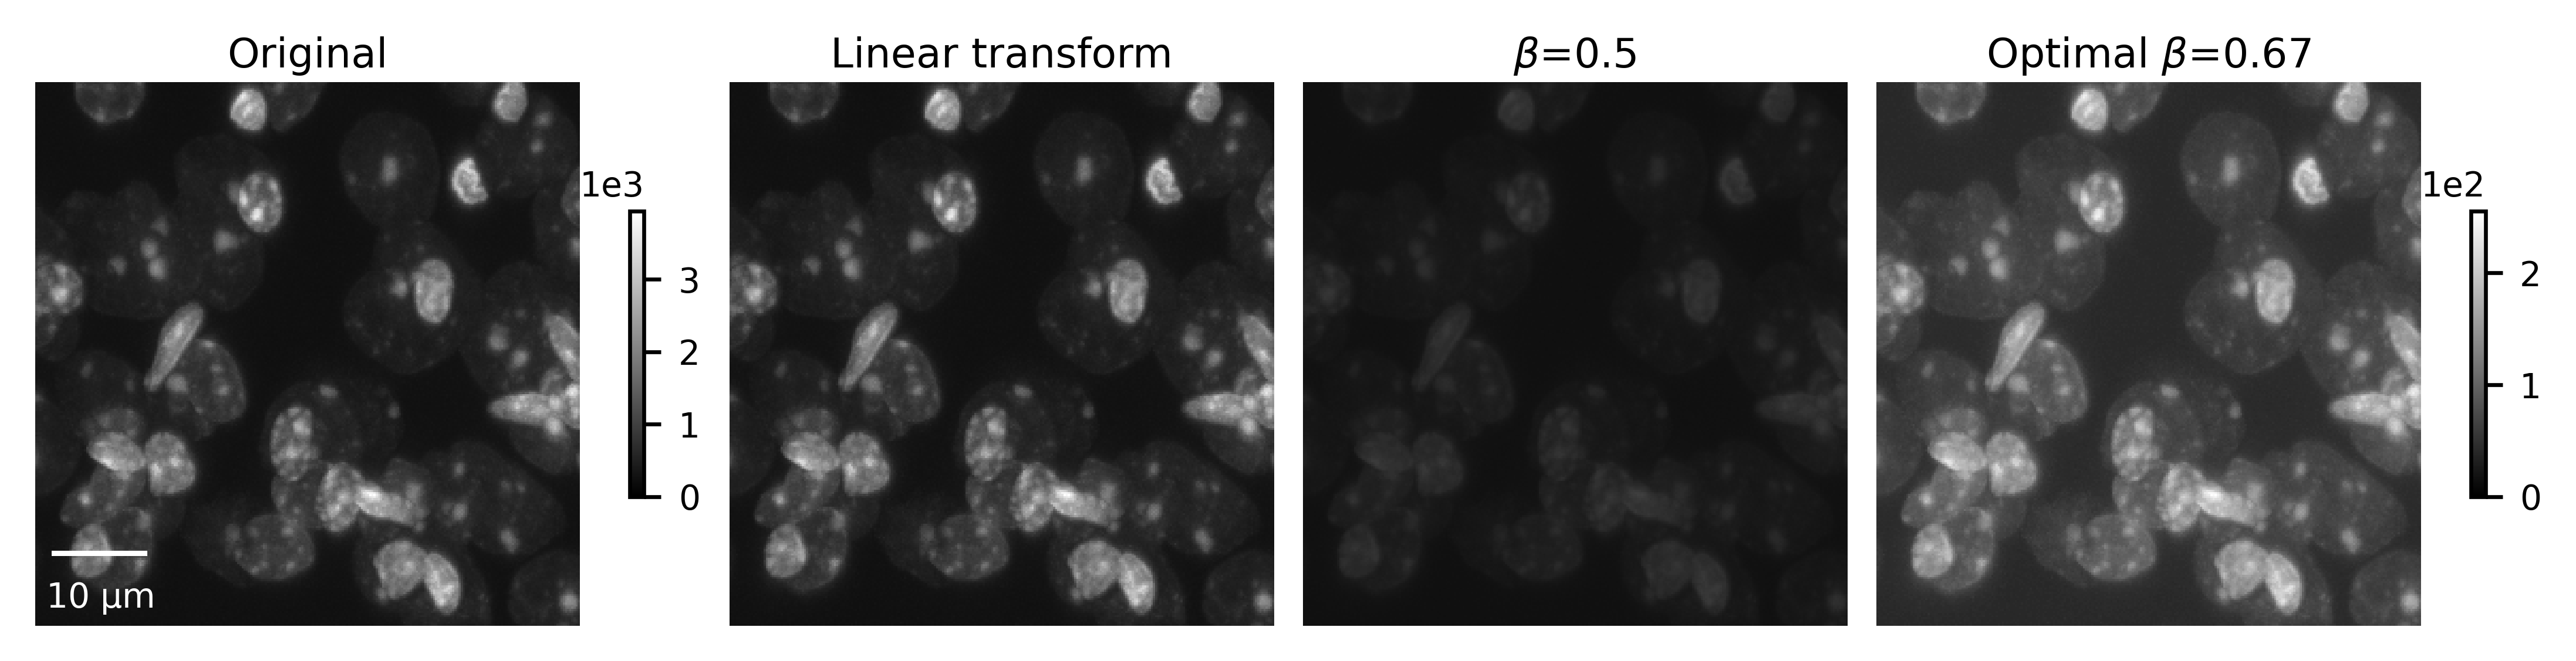

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(7.2,1.8), dpi=600, layout='constrained')
axes = axes.ravel()
handlers = []
for ax, im, name in zip(axes[:4], [img, lq, sq, gq], ['Raw', 'Linear transform', '$\\beta$=0.5', 'Optimal $\\beta$=0.67']):
    if name == 'Raw':
        vmax = np.amax(img)
        scalebar = ScaleBar(400/1.8, 'nm', location='lower left', frameon=False, color='w')
        ax.add_artist(scalebar)
        ax.set_title('Original')
    else:
        vmax = 255
        ax.set_title(name)
        
    handlers.append(ax.imshow(im, cmap='gray', vmin=0, vmax=vmax))
    ax.axis('off')

cb = plt.colorbar(handlers[0], ax=axes[0], shrink=0.5, location='right', pad=0)
cb.formatter.set_powerlimits((0, 0))

cb = plt.colorbar(handlers[-1], ax=axes[-1], shrink=0.5, location='right', pad=0)
cb.formatter.set_powerlimits((0, 0))
# fig.tight_layout()
fig.savefig('quant_raw.pdf')

In [26]:
inx1, inx2, iny1, iny2 = 140, 155, 180, 195

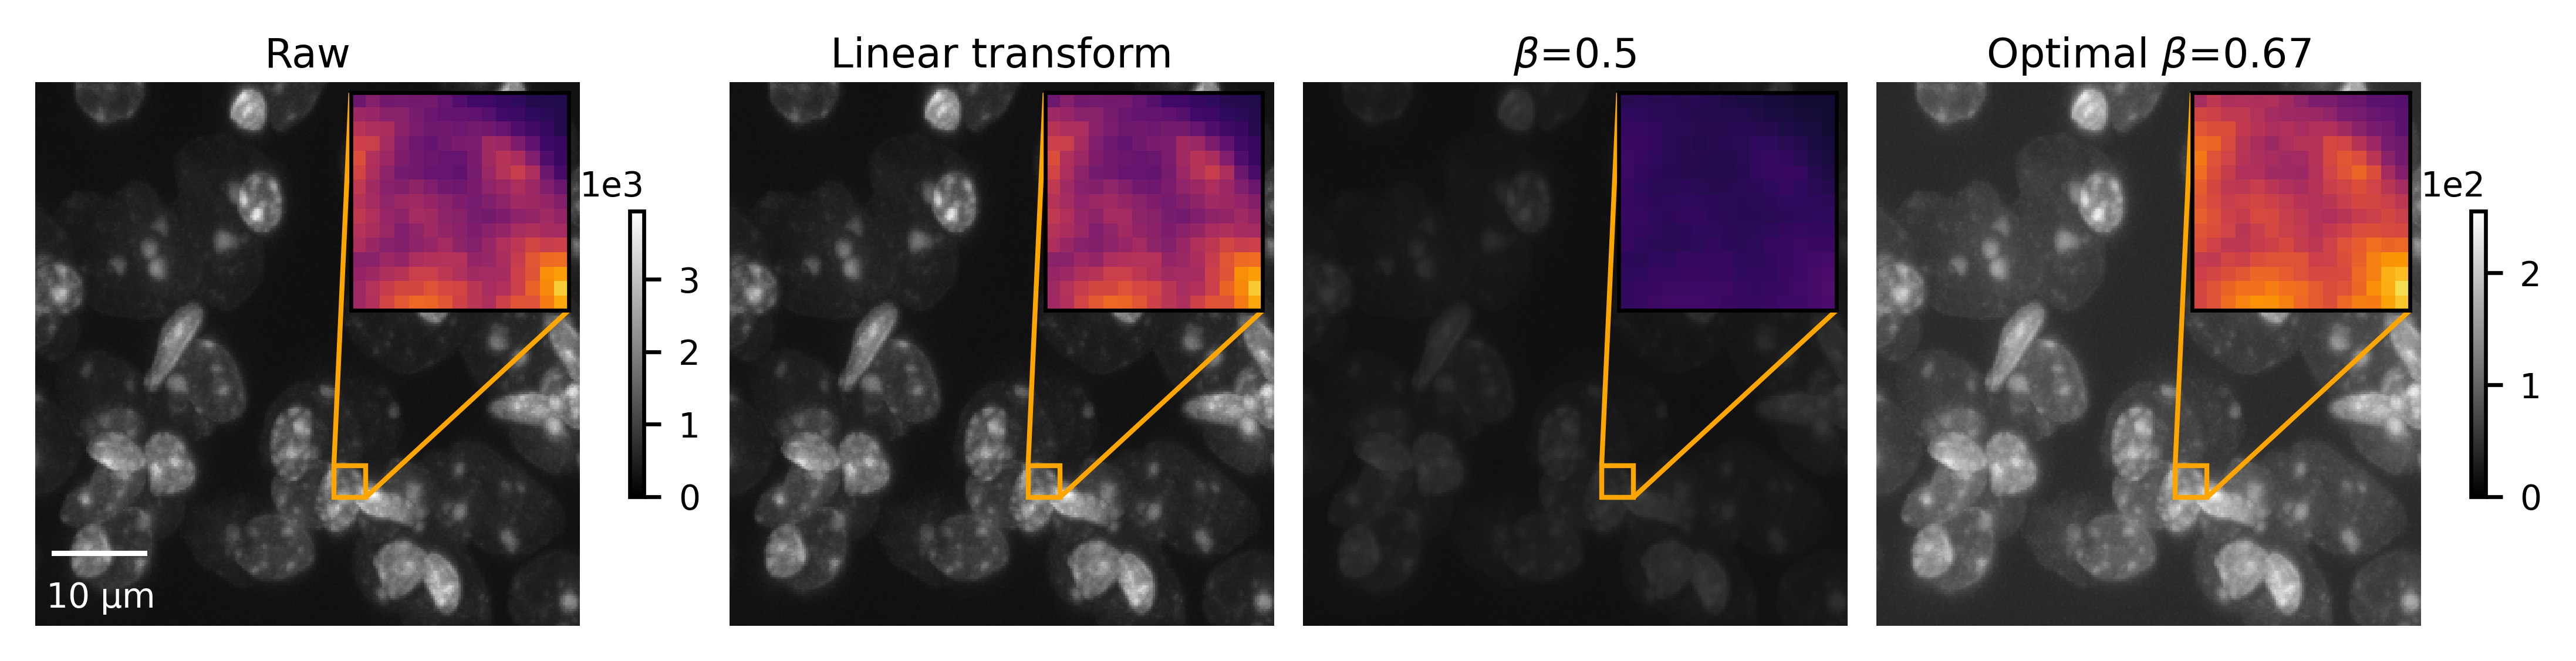

In [27]:
fig, axes = plt.subplots(1, 4, figsize=(7.2,1.8), dpi=600, layout='constrained')
axes = axes.ravel()
handlers = []
for ax, im, name in zip(axes[:4], [img, lq, sq, gq], ['Raw', 'Linear transform', '$\\beta$=0.5', 'Optimal $\\beta$=0.67']):
    if name == 'Raw':
        vmax = np.amax(img)
        scalebar = ScaleBar(400/1.8, 'nm', location='lower left', frameon=False, color='w')
        ax.add_artist(scalebar)
    else:
        vmax = 255
        
    handlers.append(ax.imshow(im, cmap='gray', vmin=0, vmax=vmax))
    # ax.plot([x0, x1], [y0, y1], 'm-', linewidth=1)
    # inset axes....
    axins = ax.inset_axes([0.58, 0.58, 0.4, 0.4])
    im_in = im[iny1:iny2, inx1:inx2]
    axins.imshow(im_in, extent=(inx1, inx2, iny2, iny1), origin="lower", cmap='inferno', vmin=0, vmax=vmax)
    # subregion of the original image
    axins.set_xlim(inx1, inx2)
    axins.set_ylim(iny1, iny2)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    axins.set_xticks([])
    axins.set_yticks([])
    # axins.axis('off')
    
    mark_inset(ax, axins, loc1=2, loc2=4, ec='orange')
    ax.axis('off')
    ax.set_title(name)

cb = plt.colorbar(handlers[0], ax=axes[0], shrink=0.5, location='right', pad=0)
cb.formatter.set_powerlimits((0, 0))

cb = plt.colorbar(handlers[-1], ax=axes[-1], shrink=0.5, location='right', pad=0)
cb.formatter.set_powerlimits((0, 0))
# fig.tight_layout()
fig.savefig('quant.pdf')

In [22]:
max_diff, min_diff = max([np.amax(en_img - en_im) for en_im in [en_lq, en_sq, en_gq]]), min([np.amin(en_img - en_im) for en_im in [en_lq, en_sq, en_gq]])
max_diff, min_diff

(4.66030320059485, 0.07272727272727231)

In [23]:
np.amax(en_img), np.amin(en_img)

(6.339850002884614, 3.9312089489103226)

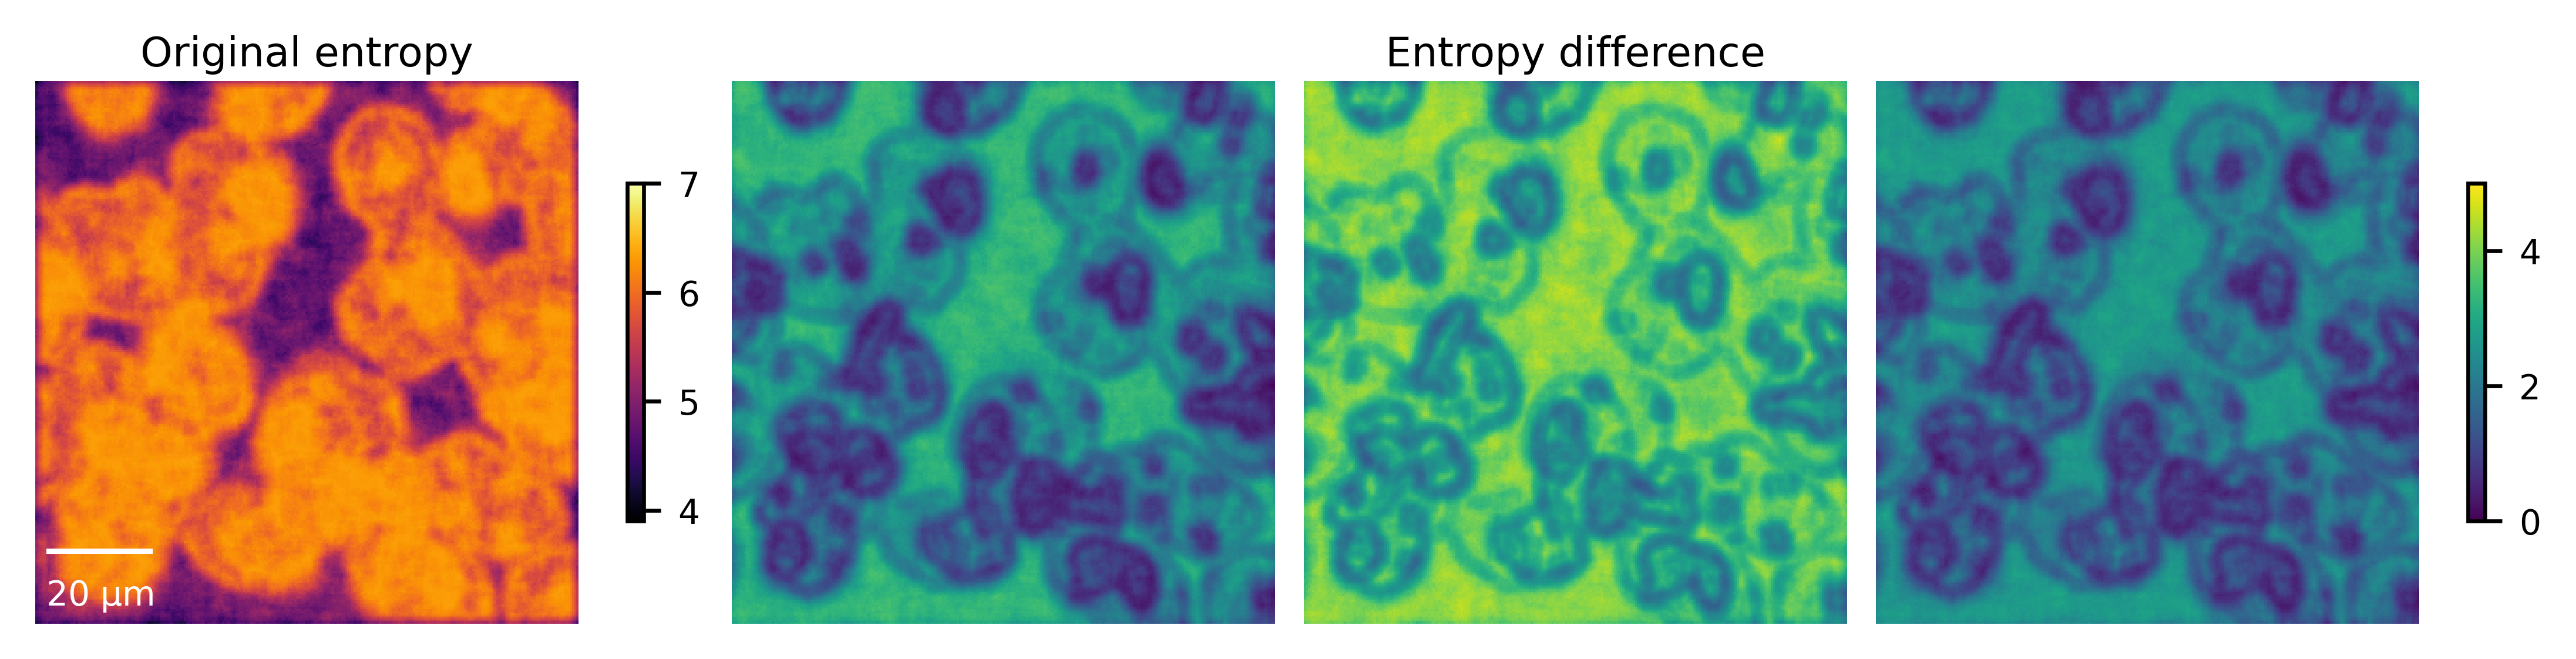

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(7.2,2), dpi=600, layout='constrained')
axes = axes.ravel()

handler = axes[0].imshow(en_img, cmap='inferno', vmin=3.9, vmax=7)
axes[0].set_title('Original entropy')
plt.colorbar(handler, ax=axes[0], shrink=0.5, location='right', pad=0.09)
scalebar = ScaleBar(400, 'nm', location='lower left', frameon=False, color='w')
axes[0].add_artist(scalebar)

axes[1].imshow(en_img - en_lq, cmap='viridis', vmin=0, vmax=5)

axes[2].imshow(en_img - en_sq, cmap='viridis', vmin=0, vmax=5)
axes[2].set_title("Entropy difference")
handler = axes[3].imshow(en_img - en_gq, cmap='viridis', vmin=0, vmax=5)
plt.colorbar(handler, ax=axes[-1], shrink=0.5, location='right', pad=0.09)

for ax in axes:
    ax.axis('off')

# fig.tight_layout()
fig.savefig('entropy.pdf')

In [25]:
var_img = window_variance(np.array(img, dtype=float), radius=5) ** 0.5
var_lq = window_variance(np.array(rec_lq, dtype=float), radius=5) ** 0.5
var_sq = window_variance(np.array(rec_sq, dtype=float), radius=5) ** 0.5
var_gq = window_variance(np.array(rec_gq, dtype=float), radius=5) ** 0.5

In [26]:
diffs_lq = (var_img - var_lq) / img.astype(float)[:-9, :-9]
diffs_sq = (var_img - var_sq) / img.astype(float)[:-9, :-9]
diffs_gq = (var_img - var_gq) / img.astype(float)[:-9, :-9]

In [27]:
print(diffs_lq.max(), diffs_lq.min())
print(diffs_sq.max(), diffs_sq.min())
print(diffs_gq.max(), diffs_gq.min())

0.005885034354943514 -0.011599377332710005
0.016954948552001775 -0.03016652187009635
0.004155514329000831 -0.004584360389388497


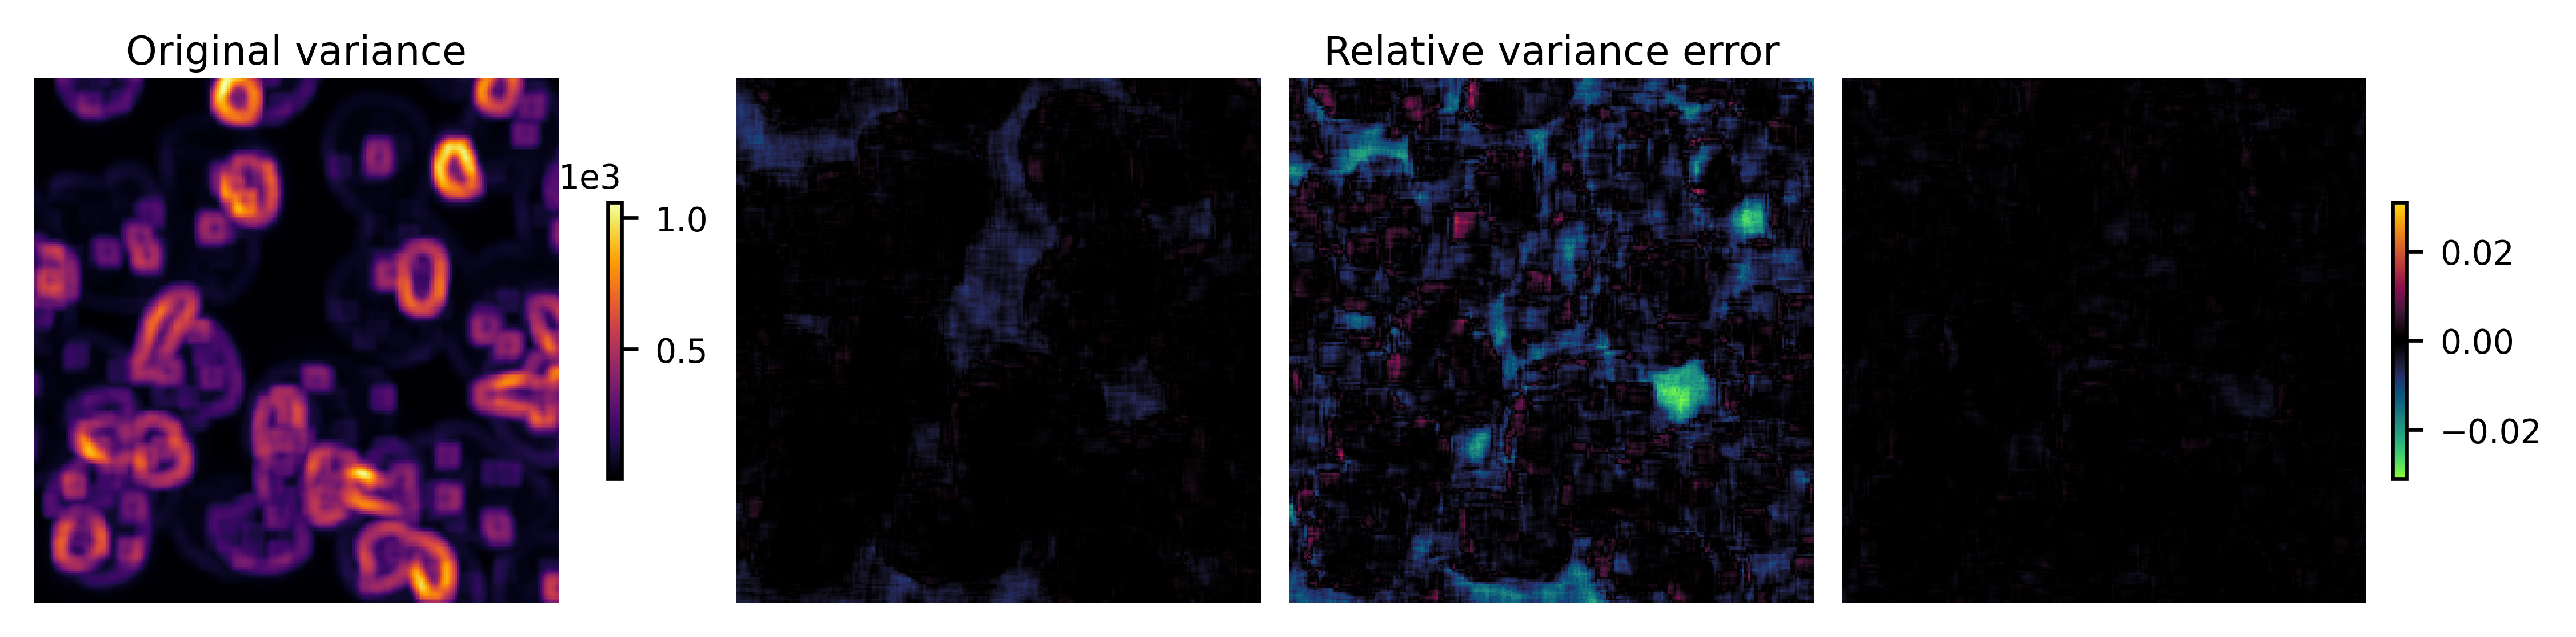

In [28]:
fig, axes = plt.subplots(1, 4, figsize=(7.4,2.1), dpi=600, layout='constrained')
axes = axes.ravel()
cmap = 'cmr.wildfire'
handler = axes[0].imshow(var_img, cmap='inferno')
axes[0].set_title('Original variance')
cb = plt.colorbar(handler, ax=axes[0], shrink=0.4, location='right', pad=0.)
cb.formatter.set_powerlimits((0, 0))

axes[1].imshow(diffs_lq, cmap=cmap, vmin=-0.031, vmax=0.031)
axes[2].imshow(diffs_sq, cmap=cmap, vmin=-0.031, vmax=0.031)
axes[2].set_title("Relative variance error")
handler = axes[3].imshow(diffs_gq, cmap=cmap, vmin=-0.031, vmax=0.031)

# axes[1].add_artist(AnchoredText(f'Range:{np.amin(diffs_lq):.2f}-{np.amax(diffs_lq):.2f}', borderpad=0, pad=0.1, prop=dict(size=7, color='w'), frameon=False, loc='upper left'))
# axes[2].add_artist(AnchoredText(f'Range:{np.amin(diffs_sq):.2f}-{np.amax(diffs_sq):.2f}', borderpad=0, pad=0.1, prop=dict(size=7, color='w'), frameon=False, loc='upper left'))
# axes[3].add_artist(AnchoredText(f'Range:{np.amin(diffs_gq):.2f}-{np.amax(diffs_gq):.2f}', borderpad=0, pad=0.1, prop=dict(size=7, color='w'), frameon=False, loc='upper left'))
    
plt.colorbar(handler, ax=axes[-1], shrink=0.4, location='right', pad=0.05)

for ax in axes:
    ax.axis('off')

# fig.tight_layout()
fig.savefig('variance.pdf')